In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os
import timm


c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


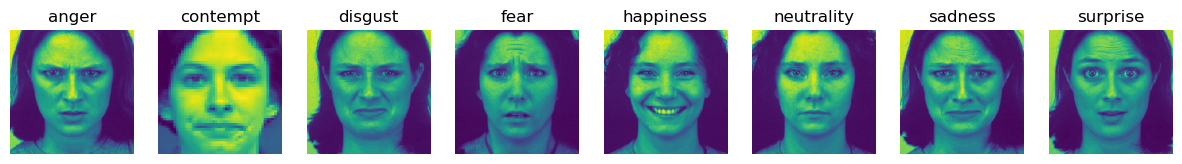

In [13]:
# Define the train directory path
train_dir = r'D:\university\FER\fer_ckplus_kdef\train'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor()
])

# Load the dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
class_names = train_dataset.classes

# Create a dictionary to store one image per class
class_samples = {}

for img_path, label in train_dataset.imgs:
    class_name = class_names[label]
    if class_name not in class_samples:
        class_samples[class_name] = img_path

# Display one image per class
fig, axes = plt.subplots(1, len(class_samples), figsize=(15, 5))

for idx, (class_name, img_path) in enumerate(class_samples.items()):
    image = plt.imread(img_path)
    axes[idx].imshow(image)
    axes[idx].set_title(class_name)
    axes[idx].axis('off')

plt.show()

In [3]:
dataset_path = r'D:\university\FER\fer_ckplus_kdef'
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

# Data Augmentation for Train Set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(112, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Validation and Test Transformations
val_test_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# Dataloader setup
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")


Train size: 23650, Validation size: 2631, Test size: 6573



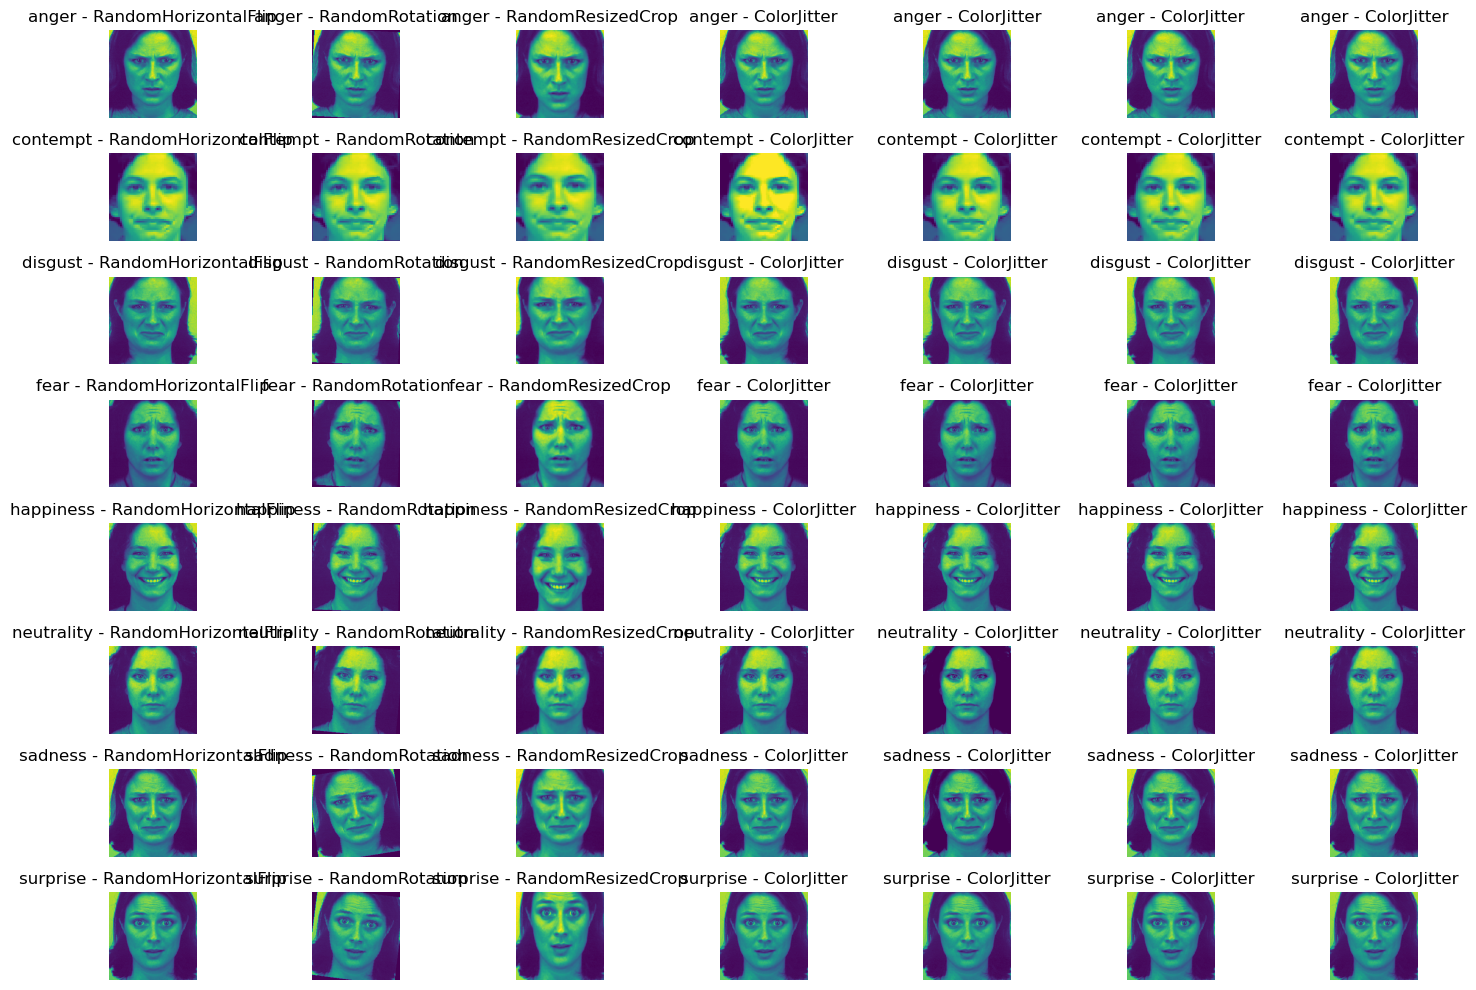

In [14]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image

# Define the train directory path
train_dir = r'D:\university\FER\fer_ckplus_kdef\train'

# Define data augmentation transformations with color variations
augmentation_transforms = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(112, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.5),
    transforms.ColorJitter(contrast=0.5),
    transforms.ColorJitter(saturation=0.5),
    transforms.ColorJitter(hue=0.3)
]

# Load the dataset
train_dataset = datasets.ImageFolder(root=train_dir)
class_names = train_dataset.classes

# Select one sample image from each class
class_samples = {}

for img_path, label in train_dataset.imgs:
    class_name = class_names[label]
    if class_name not in class_samples:
        class_samples[class_name] = img_path

# Display augmented images with different color transformations
fig, axes = plt.subplots(len(class_samples), len(augmentation_transforms), figsize=(15, 10))

for row_idx, (class_name, img_path) in enumerate(class_samples.items()):
    image = Image.open(img_path)

    for col_idx, transform in enumerate(augmentation_transforms):
        augmented_image = transform(image)
        augmented_image = transforms.ToTensor()(augmented_image).permute(1, 2, 0).numpy()  # Convert to numpy array
        axes[row_idx, col_idx].imshow(augmented_image)
        axes[row_idx, col_idx].set_title(f"{class_name} - {transform.__class__.__name__}")
        axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()


In [4]:
class CNNTransFERNet(nn.Module):
    def __init__(self, num_classes):
        super(CNNTransFERNet, self).__init__()
        
        # Pretrained EfficientNet backbone
        self.cnn = timm.create_model('efficientnet_b0', pretrained=True)
        self.cnn.classifier = nn.Identity()  # Remove the final classification layer
        
        # Fully connected layers with dropout
        self.fc1 = nn.Linear(1280, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.3)

        # Transformer Encoder Layer
        self.transformer = nn.TransformerEncoderLayer(d_model=512, nhead=8)

        # Final classifier
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.transformer(x.unsqueeze(0))
        x = self.fc2(x.squeeze(0))
        return x

num_classes = len(train_dataset.classes)
model = CNNTransFERNet(num_classes=num_classes).to(device)
print(model)


CNNTransFERNet(
  (cnn): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Con

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Reduce LR if validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)


c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [6]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    early_stopping = EarlyStopping(patience=5)

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        val_epoch_loss, val_epoch_acc = evaluate_model(model, val_loader, criterion)
        scheduler.step(val_epoch_loss)
        
        train_loss.append(epoch_loss)
        val_loss.append(val_epoch_loss)
        train_acc.append(epoch_acc)
        val_acc.append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

        if early_stopping(val_epoch_loss):
            print("Early stopping triggered.")
            break

    return train_loss, val_loss, train_acc, val_acc


In [7]:
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [8]:
num_epochs = 120
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)


Epoch 1/120 -> Train Loss: 1.3876, Train Acc: 0.4967, Val Loss: 1.1987, Val Acc: 0.5739
Epoch 2/120 -> Train Loss: 1.1719, Train Acc: 0.5806, Val Loss: 1.1608, Val Acc: 0.5766
Epoch 3/120 -> Train Loss: 1.1343, Train Acc: 0.5959, Val Loss: 1.0374, Val Acc: 0.6347
Epoch 4/120 -> Train Loss: 1.0835, Train Acc: 0.6146, Val Loss: 1.0858, Val Acc: 0.5967
Epoch 5/120 -> Train Loss: 1.0382, Train Acc: 0.6335, Val Loss: 0.9976, Val Acc: 0.6420
Epoch 6/120 -> Train Loss: 1.0105, Train Acc: 0.6394, Val Loss: 1.0427, Val Acc: 0.6283
Epoch 7/120 -> Train Loss: 0.9822, Train Acc: 0.6542, Val Loss: 1.0065, Val Acc: 0.6408
Epoch 8/120 -> Train Loss: 0.9583, Train Acc: 0.6626, Val Loss: 0.9698, Val Acc: 0.6553
Epoch 9/120 -> Train Loss: 0.9392, Train Acc: 0.6709, Val Loss: 0.9592, Val Acc: 0.6625
Epoch 10/120 -> Train Loss: 0.9315, Train Acc: 0.6733, Val Loss: 0.9857, Val Acc: 0.6439
Epoch 11/120 -> Train Loss: 0.9067, Train Acc: 0.6836, Val Loss: 0.9191, Val Acc: 0.6727
Epoch 12/120 -> Train Loss: 0.

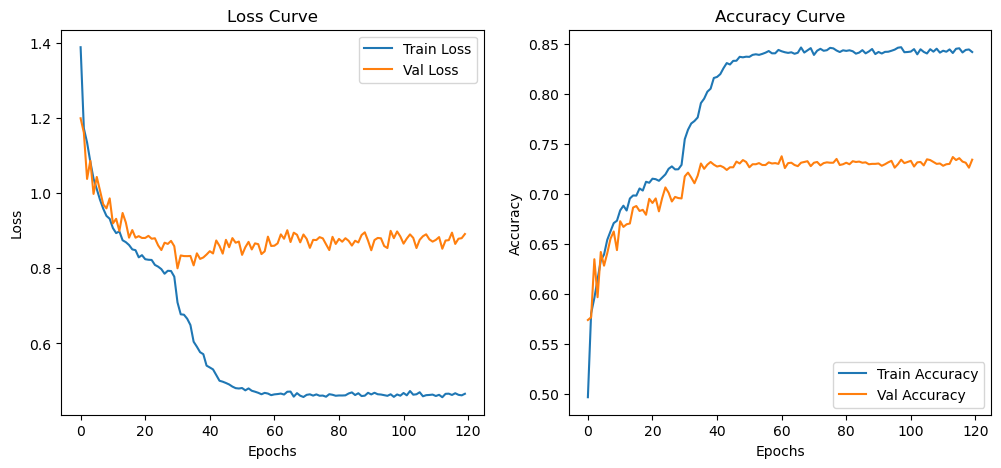

In [9]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_metrics(train_loss, val_loss, train_acc, val_acc)


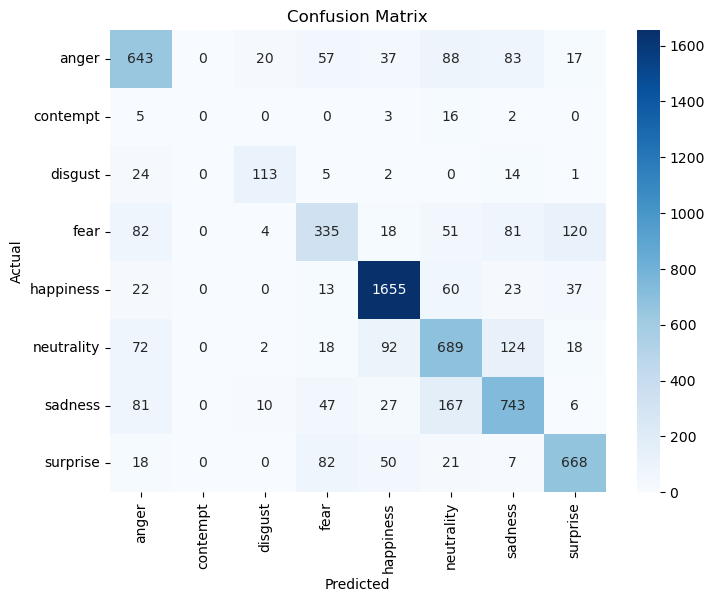

Classification Report:
              precision    recall  f1-score   support

       anger       0.68      0.68      0.68       945
    contempt       0.00      0.00      0.00        26
     disgust       0.76      0.71      0.73       159
        fear       0.60      0.48      0.54       691
   happiness       0.88      0.91      0.90      1810
  neutrality       0.63      0.68      0.65      1015
     sadness       0.69      0.69      0.69      1081
    surprise       0.77      0.79      0.78       846

    accuracy                           0.74      6573
   macro avg       0.63      0.62      0.62      6573
weighted avg       0.73      0.74      0.73      6573



c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shayon\anaconda3\envs\SHgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
def test_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_labels = train_dataset.classes

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_labels))

test_model(model, test_loader)


In [11]:
torch.save(model.state_dict(), 'cnn_transFERNet.pth')
print("Model saved successfully.")


Model saved successfully.


In [12]:
import torch
model_save_path = "cnn_transFERNet.pth"
torch.save(model.state_dict(), model_save_path)
print("Model saved successfully.")


Model saved successfully.
